In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, recall_score, precision_score
import psycopg2
import time

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
table_cols = [('age_group', 'reporting_phu_city', 'cause_of_infection', 'gender', 'Resolved', 'Fatal', 'Special_Measure_Key')]
fact_table = []

def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        return psycopg2.connect(
            host="www.eecs.uottawa.ca",
            database="group_21",
            user="****",
            password="****",
            port="15432"
        )
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)


connection = connect()
print('***Connection established***')

cur = connection.cursor()
        
cur.execute('SELECT I.age_group, I.reporting_phu_city,\
            I.cause_of_infection, I.gender, F."Resolved",\
            F."Fatal", F."Special_Measure_Key" FROM fact_table_v2 as F\
            INNER JOIN individuals as I on I.individual_id = F."Individual_Key"')
rows = cur.fetchall()
fact_table = rows
print(fact_table[:10])

cur.close()
connection.close()
print('***Connection terminated***')

Connecting to the PostgreSQL database...
***Connection established***
[('40s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('30s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('90+', 'Toronto', 'OB', 'FEMALE', 'no', 'yes', 11), ('80s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('50s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('30s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('50s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('50s', 'Toronto', 'OB', 'MALE', 'yes', 'no', 11), ('20s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('80s', 'Toronto', 'NO KNOWN EPI LINK', 'FEMALE', 'yes', 'no', 2)]
***Connection terminated***


In [3]:
result_df = pd.DataFrame(fact_table, columns=["age_group", "reporting_phu_city", "cause_of_infection", 
                                               "gender", "Resolved","Fatal","Special_Measure_Key"])
result_df.head()

,age_group,reporting_phu_city,cause_of_infection,gender,Resolved,Fatal,Special_Measure_Key
0,40s,Toronto,OB,FEMALE,yes,no,11
1,30s,Toronto,OB,FEMALE,yes,no,11
2,90+,Toronto,OB,FEMALE,no,yes,11
3,80s,Toronto,OB,FEMALE,yes,no,11
4,50s,Toronto,OB,FEMALE,yes,no,11


In [4]:
new_result_df = pd.get_dummies(result_df, prefix=["age_group", "reporting_phu_city", "cause_of_infection", "gender", "Resolved", "Fatal"])
new_result_df = pd.concat([new_result_df, result_df["age_group"]], axis=1)
X = new_result_df.values
new_result_df.head()

,Special_Measure_Key,age_group_20s,age_group_30s,age_group_40s,age_group_50s,age_group_60s,age_group_70s,age_group_80s,age_group_90+,age_group_<20,age_group_UNKNOWN,reporting_phu_city_Ottawa,reporting_phu_city_Toronto,cause_of_infection_CC,cause_of_infection_MISSING INFORMATION,cause_of_infection_NO KNOWN EPI LINK,cause_of_infection_OB,cause_of_infection_TRAVEL,gender_FEMALE,gender_GENDER DIVERSE,gender_MALE,gender_UNSPECIFIED,Resolved_no,Resolved_yes,Fatal_no,Fatal_yes,age_group
0,11,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,40s
1,11,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,30s
2,11,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,90+
3,11,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,80s
4,11,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,50s


In [5]:
# Create Labeler and Encoder
labelencoder = LabelEncoder()
encoder = OneHotEncoder(dtype=int, handle_unknown='ignore')
# Assigning numerical values and storing in another column
new_result_df['Special_Measure_Key_Tmp'] = labelencoder.fit_transform(new_result_df['Special_Measure_Key'])
new_result_df.head()

,Special_Measure_Key,age_group_20s,age_group_30s,age_group_40s,age_group_50s,age_group_60s,age_group_70s,age_group_80s,age_group_90+,age_group_<20,age_group_UNKNOWN,reporting_phu_city_Ottawa,reporting_phu_city_Toronto,cause_of_infection_CC,cause_of_infection_MISSING INFORMATION,cause_of_infection_NO KNOWN EPI LINK,cause_of_infection_OB,cause_of_infection_TRAVEL,gender_FEMALE,gender_GENDER DIVERSE,gender_MALE,gender_UNSPECIFIED,Resolved_no,Resolved_yes,Fatal_no,Fatal_yes,age_group,Special_Measure_Key_Tmp
0,11,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,40s,6
1,11,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,30s,6
2,11,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,90+,6
3,11,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,80s,6
4,11,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,50s,6


In [6]:
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(encoder.fit_transform(new_result_df[['Special_Measure_Key_Tmp']]).toarray())
#  merge with main df bridge_df on key values
new_result_df = new_result_df.join(enc_df)
new_result_df.rename(columns={6: "lockdown", 10: "stage 3 extended to toronto", 2: "Restart", 1: "Gatineau-Ottawa Travel Restriction", 3: "Parks Re-opened"},inplace = True)
new_result_df = new_result_df.drop(['Special_Measure_Key_Tmp'], axis=1)
new_result_df.head()

,Special_Measure_Key,age_group_20s,age_group_30s,age_group_40s,age_group_50s,age_group_60s,age_group_70s,age_group_80s,age_group_90+,age_group_<20,age_group_UNKNOWN,reporting_phu_city_Ottawa,reporting_phu_city_Toronto,cause_of_infection_CC,cause_of_infection_MISSING INFORMATION,cause_of_infection_NO KNOWN EPI LINK,cause_of_infection_OB,cause_of_infection_TRAVEL,gender_FEMALE,gender_GENDER DIVERSE,gender_MALE,gender_UNSPECIFIED,Resolved_no,Resolved_yes,Fatal_no,Fatal_yes,age_group,0,Gatineau-Ottawa Travel Restriction,Restart,Parks Re-opened,4,5,lockdown
0,11,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,40s,0,0,0,0,0,0,1
1,11,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,30s,0,0,0,0,0,0,1
2,11,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,90+,0,0,0,0,0,0,1
3,11,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,80s,0,0,0,0,0,0,1
4,11,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,50s,0,0,0,0,0,0,1


In [7]:
new_result_df = new_result_df.drop(['Special_Measure_Key', 4, 5], axis=1)
new_result_df.head()

,age_group_20s,age_group_30s,age_group_40s,age_group_50s,age_group_60s,age_group_70s,age_group_80s,age_group_90+,age_group_<20,age_group_UNKNOWN,reporting_phu_city_Ottawa,reporting_phu_city_Toronto,cause_of_infection_CC,cause_of_infection_MISSING INFORMATION,cause_of_infection_NO KNOWN EPI LINK,cause_of_infection_OB,cause_of_infection_TRAVEL,gender_FEMALE,gender_GENDER DIVERSE,gender_MALE,gender_UNSPECIFIED,Resolved_no,Resolved_yes,Fatal_no,Fatal_yes,age_group,0,Gatineau-Ottawa Travel Restriction,Restart,Parks Re-opened,lockdown
0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,40s,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,30s,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,90+,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,80s,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,50s,0,0,0,0,1


In [8]:
from sklearn.utils import resample

# put undersampling into function
def undersample(column_name):
  df_majority = new_result_df[new_result_df[column_name]==False]
  df_minority = new_result_df[new_result_df[column_name]==True]

  df_majority_upsampled = resample(df_majority, 
                                  replace=True,     # sample with replacement
                                  n_samples=len(df_minority.index),    # to match minority class
                                  random_state=42)

  df_upsampled = pd.concat([df_minority, df_majority_upsampled])

  print(df_upsampled[column_name].value_counts())

  return df_upsampled

In [9]:
df_age_group_20s = undersample("age_group_20s")
df_age_group_30s = undersample("age_group_30s")
df_age_group_40s = undersample("age_group_40s")
df_age_group_50s = undersample("age_group_50s")
df_age_group_60s = undersample("age_group_60s")
df_age_group_70s = undersample("age_group_70s")
df_age_group_80s = undersample("age_group_80s")
df_age_group_90 = undersample("age_group_90+")
df_age_group_20 = undersample("age_group_<20")

1    2131
0    2131
Name: age_group_20s, dtype: int64
1    2037
0    2037
Name: age_group_30s, dtype: int64
1    2107
0    2107
Name: age_group_40s, dtype: int64
1    2397
0    2397
Name: age_group_50s, dtype: int64
1    1644
0    1644
Name: age_group_60s, dtype: int64
1    1121
0    1121
Name: age_group_70s, dtype: int64
1    1687
0    1687
Name: age_group_80s, dtype: int64
1    1283
0    1283
Name: age_group_90+, dtype: int64
1    848
0    848
Name: age_group_<20, dtype: int64


### Class - Age 20s

In [10]:
df_age_group_20s.drop(['age_group_30s', 'age_group_40s', 'age_group_50s', 'age_group_60s', 'age_group_70s', 'age_group_80s', 'age_group_90+','age_group_<20', 'age_group_UNKNOWN', 'age_group', 0], axis=1, inplace=True)

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from collections import Counter

y = df_age_group_20s['age_group_20s']
df_age_group_20s.drop(['age_group_20s'], axis=1, inplace=True)
X = df_age_group_20s.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)

print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

Training set Counter({1: 1428, 0: 1427}) 
Test set Counter({0: 704, 1: 703}) 


In [12]:
import time
clf = GradientBoostingClassifier(n_estimators=20, max_features=2, max_depth=2, random_state=0)
t0 = time.perf_counter()
clf.fit(X_train, y_train)
t1 = time.perf_counter() - t0

In [13]:
print("Time to construct model ", t1)
print("Accuracy score (training): {0:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(clf.score(X_test, y_test)))

from sklearn.metrics import classification_report
predictions = clf.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

Time to construct model  0.034432640000005676
Accuracy score (training): 0.649
Accuracy score (testing): 0.657
Classification Report
              precision    recall  f1-score   support

           0       0.72      0.51      0.60       704
           1       0.62      0.80      0.70       703

    accuracy                           0.66      1407
   macro avg       0.67      0.66      0.65      1407
weighted avg       0.67      0.66      0.65      1407



In [83]:
# Gradient boosting models are comprised of hundreds of regression trees and therefore are not easy to visualize
# Instead we can look at what are the important features and how they contributed to the prediction
def plot_feature_importance(features):
  std = np.std([clf.feature_importances_ for tree in clf.estimators_], axis=0)
  indices = np.argsort(importances)[::-1]
  print("Feature ranking:")
  for f in range(X.shape[1]):
      print("%d. %s (%f)" % (indices[f], features[indices[f]], importances[indices[f]]))

  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(X.shape[1]), importances[indices],
          color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()

Feature ranking:
5. cause_of_infection_OB (0.290508)
11. Resolved_no (0.255690)
2. cause_of_infection_CC (0.156159)
18. lockdown (0.095179)
13. Fatal_no (0.051641)
12. Resolved_yes (0.050513)
14. Fatal_yes (0.035275)
17. Parks Re-opened (0.024950)
0. reporting_phu_city_Ottawa (0.014035)
4. cause_of_infection_NO KNOWN EPI LINK (0.006040)
10. gender_UNSPECIFIED (0.004554)
3. cause_of_infection_MISSING INFORMATION (0.004331)
9. gender_MALE (0.003322)
6. cause_of_infection_TRAVEL (0.002865)
7. gender_FEMALE (0.002226)
15. Gatineau-Ottawa Travel Restriction (0.001699)
1. reporting_phu_city_Toronto (0.001011)
8. gender_GENDER DIVERSE (0.000000)
16. Restart (0.000000)


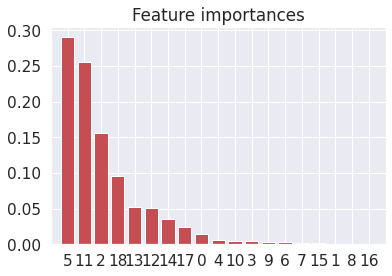

In [84]:
features = []
for col in df_age_group_20s.columns:    
    features.append(col)

plot_feature_importance(features)

### Class - Age <20s

In [ ]:
# preprocessing
df_age_group_20.drop(['age_group_20s', 'age_group_30s', 'age_group_40s', 'age_group_50s', 'age_group_60s', 'age_group_70s', 'age_group_80s', 'age_group_90+', 'age_group_UNKNOWN', 'age_group', 0], axis=1, inplace=True)
y = df_age_group_20['age_group_<20']
df_age_group_20.drop(['age_group_<20'], axis=1, inplace=True)
X = df_age_group_20.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

# classify
clf = GradientBoostingClassifier(n_estimators=20, max_features=2, max_depth=2, random_state=0)
t0 = time.perf_counter()
clf.fit(X_train, y_train)
t1 = time.perf_counter() - t0

# evaluation
print("Time to construct model ", t1)
print("Accuracy score (training): {0:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(clf.score(X_test, y_test)))
predictions = clf.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

Training set Counter({1: 568, 0: 568}) 
Test set Counter({0: 280, 1: 280}) 
Time to construct model  0.01559055599864223
Accuracy score (training): 0.733
Accuracy score (testing): 0.730
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       280
           1       0.70      0.80      0.75       280

    accuracy                           0.73       560
   macro avg       0.73      0.73      0.73       560
weighted avg       0.73      0.73      0.73       560



### Class - Age 30s

In [89]:
# preprocessing
df_age_group_30s.drop(['age_group_20s', 'age_group_40s', 'age_group_50s', 'age_group_60s', 'age_group_70s', 'age_group_80s', 'age_group_90+','age_group_<20', 'age_group_UNKNOWN', 'age_group', 0], axis=1, inplace=True)
y = df_age_group_30s['age_group_30s']
df_age_group_30s.drop(['age_group_30s'], axis=1, inplace=True)
X = df_age_group_30s.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

# classify
clf = GradientBoostingClassifier(n_estimators=20, max_features=2, max_depth=2, random_state=0)
t0 = time.perf_counter()
clf.fit(X_train, y_train)
t1 = time.perf_counter() - t0

# evaluation
print("Time to construct model ", t1)
print("Accuracy score (training): {0:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(clf.score(X_test, y_test)))
predictions = clf.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

Training set Counter({1: 1365, 0: 1364}) 
Test set Counter({0: 673, 1: 672}) 
Time to construct model  0.02400278499999331
Accuracy score (training): 0.598
Accuracy score (testing): 0.587
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.44      0.52       673
           1       0.57      0.73      0.64       672

    accuracy                           0.59      1345
   macro avg       0.60      0.59      0.58      1345
weighted avg       0.60      0.59      0.58      1345



### Class - Age 40s

In [91]:
# preprocessing
df_age_group_40s.drop(['age_group_20s', 'age_group_30s', 'age_group_50s', 'age_group_60s', 'age_group_70s', 'age_group_80s', 'age_group_90+','age_group_<20', 'age_group_UNKNOWN', 'age_group', 0], axis=1, inplace=True)
y = df_age_group_40s['age_group_40s']
df_age_group_40s.drop(['age_group_40s'], axis=1, inplace=True)
X = df_age_group_40s.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

# classify
clf = GradientBoostingClassifier(n_estimators=20, max_features=2, max_depth=2, random_state=0)
t0 = time.perf_counter()
clf.fit(X_train, y_train)
t1 = time.perf_counter() - t0

# evaluation
print("Time to construct model ", t1)
print("Accuracy score (training): {0:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(clf.score(X_test, y_test)))
predictions = clf.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

Training set Counter({1: 1412, 0: 1411}) 
Test set Counter({0: 696, 1: 695}) 
Time to construct model  0.022408750000067812
Accuracy score (training): 0.567
Accuracy score (testing): 0.559
Classification Report
              precision    recall  f1-score   support

           0       0.58      0.45      0.50       696
           1       0.55      0.67      0.60       695

    accuracy                           0.56      1391
   macro avg       0.56      0.56      0.55      1391
weighted avg       0.56      0.56      0.55      1391



### Class - Age 50s

In [ ]:
# preprocessing
df_age_group_50s.drop(['age_group_20s', 'age_group_30s', 'age_group_40s', 'age_group_60s', 'age_group_70s', 'age_group_80s', 'age_group_90+','age_group_<20', 'age_group_UNKNOWN', 'age_group', 0], axis=1, inplace=True)
y = df_age_group_50s['age_group_50s']
df_age_group_50s.drop(['age_group_50s'], axis=1, inplace=True)
X = df_age_group_50s.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

# classify
clf = GradientBoostingClassifier(n_estimators=20, max_features=2, max_depth=2, random_state=0)
t0 = time.perf_counter()
clf.fit(X_train, y_train)
t1 = time.perf_counter() - t0

# evaluation
print("Time to construct model ", t1)
print("Accuracy score (training): {0:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(clf.score(X_test, y_test)))
predictions = clf.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

Training set Counter({1: 1606, 0: 1605}) 
Test set Counter({0: 792, 1: 791}) 
Time to construct model  0.026902548999999
Accuracy score (training): 0.562
Accuracy score (testing): 0.539
Classification Report
              precision    recall  f1-score   support

           0       0.61      0.21      0.32       792
           1       0.52      0.86      0.65       791

    accuracy                           0.54      1583
   macro avg       0.57      0.54      0.48      1583
weighted avg       0.57      0.54      0.48      1583



### Class - Age 60s

In [ ]:
# preprocessing
df_age_group_60s.drop(['age_group_20s', 'age_group_30s', 'age_group_40s', 'age_group_50s', 'age_group_70s', 'age_group_80s', 'age_group_90+','age_group_<20', 'age_group_UNKNOWN', 'age_group', 0], axis=1, inplace=True)
y = df_age_group_60s['age_group_60s']
df_age_group_60s.drop(['age_group_60s'], axis=1, inplace=True)
X = df_age_group_60s.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

# classify
clf = GradientBoostingClassifier(n_estimators=20, max_features=2, max_depth=2, random_state=0)
t0 = time.perf_counter()
clf.fit(X_train, y_train)
t1 = time.perf_counter() - t0

# evaluation
print("Time to construct model ", t1)
print("Accuracy score (training): {0:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(clf.score(X_test, y_test)))
predictions = clf.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

Training set Counter({1: 1101, 0: 1101}) 
Test set Counter({0: 543, 1: 543}) 
Time to construct model  0.018075524999972004
Accuracy score (training): 0.556
Accuracy score (testing): 0.562
Classification Report
              precision    recall  f1-score   support

           0       0.57      0.49      0.53       543
           1       0.55      0.63      0.59       543

    accuracy                           0.56      1086
   macro avg       0.56      0.56      0.56      1086
weighted avg       0.56      0.56      0.56      1086



### Class - Age 70s

In [ ]:
# preprocessing
df_age_group_70s.drop(['age_group_20s', 'age_group_30s', 'age_group_40s', 'age_group_50s', 'age_group_60s', 'age_group_80s', 'age_group_90+','age_group_<20', 'age_group_UNKNOWN', 'age_group', 0], axis=1, inplace=True)
y = df_age_group_70s['age_group_70s']
df_age_group_70s.drop(['age_group_70s'], axis=1, inplace=True)
X = df_age_group_70s.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

# classify
clf = GradientBoostingClassifier(n_estimators=20, max_features=2, max_depth=2, random_state=0)
t0 = time.perf_counter()
clf.fit(X_train, y_train)
t1 = time.perf_counter() - t0

# evaluation
print("Time to construct model ", t1)
print("Accuracy score (training): {0:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(clf.score(X_test, y_test)))
predictions = clf.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

Training set Counter({0: 751, 1: 751}) 
Test set Counter({0: 370, 1: 370}) 
Time to construct model  0.017451880999999503
Accuracy score (training): 0.618
Accuracy score (testing): 0.577
Classification Report
              precision    recall  f1-score   support

           0       0.60      0.47      0.53       370
           1       0.56      0.68      0.62       370

    accuracy                           0.58       740
   macro avg       0.58      0.58      0.57       740
weighted avg       0.58      0.58      0.57       740



### Class - Age 80s

In [ ]:
# preprocessing
df_age_group_80s.drop(['age_group_20s', 'age_group_30s', 'age_group_40s', 'age_group_50s', 'age_group_60s', 'age_group_70s', 'age_group_90+','age_group_<20', 'age_group_UNKNOWN', 'age_group', 0], axis=1, inplace=True)
y = df_age_group_80s['age_group_80s']
df_age_group_80s.drop(['age_group_80s'], axis=1, inplace=True)
X = df_age_group_80s.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

# classify
clf = GradientBoostingClassifier(n_estimators=20, max_features=2, max_depth=2, random_state=0)
t0 = time.perf_counter()
clf.fit(X_train, y_train)
t1 = time.perf_counter() - t0

# evaluation
print("Time to construct model ", t1)
print("Accuracy score (training): {0:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(clf.score(X_test, y_test)))
predictions = clf.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

Training set Counter({0: 1130, 1: 1130}) 
Test set Counter({1: 557, 0: 557}) 
Time to construct model  0.02692288200000803
Accuracy score (training): 0.735
Accuracy score (testing): 0.748
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.60      0.70       557
           1       0.69      0.90      0.78       557

    accuracy                           0.75      1114
   macro avg       0.77      0.75      0.74      1114
weighted avg       0.77      0.75      0.74      1114



### Class - Age 90s

In [ ]:
# preprocessing
df_age_group_90.drop(['age_group_20s', 'age_group_30s', 'age_group_40s', 'age_group_50s', 'age_group_60s', 'age_group_70s', 'age_group_80s','age_group_<20', 'age_group_UNKNOWN', 'age_group', 0], axis=1, inplace=True)
y = df_age_group_90['age_group_90+']
df_age_group_90.drop(['age_group_90+'], axis=1, inplace=True)
X = df_age_group_90.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)
print("Training set {} ".format(Counter(y_train)))
print("Test set {} ".format(Counter(y_test)))

# classify
clf = GradientBoostingClassifier(n_estimators=20, max_features=2, max_depth=2, random_state=0)
t0 = time.perf_counter()
clf.fit(X_train, y_train)
t1 = time.perf_counter() - t0

# evaluation
print("Time to construct model ", t1)
print("Accuracy score (training): {0:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(clf.score(X_test, y_test)))
predictions = clf.predict(X_test)
print("Classification Report")
print(classification_report(y_test, predictions))

Training set Counter({0: 860, 1: 859}) 
Test set Counter({1: 424, 0: 423}) 
Time to construct model  0.017134085000009236
Accuracy score (training): 0.780
Accuracy score (testing): 0.784
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.68      0.76       423
           1       0.73      0.89      0.81       424

    accuracy                           0.78       847
   macro avg       0.80      0.78      0.78       847
weighted avg       0.80      0.78      0.78       847

